In [2]:
from pylab import *
import pyfits
import seaborn as sns
import pandas as pd
%matplotlib inline

In [3]:
shelacat = pyfits.open('data/shela_z+irac-2.1-ec_final_wFlags.fit')[1].data
sheladict = {'mem_match_id':shelacat['MEM_MATCH_ID'].byteswap().newbyteorder(),'ra':shelacat['RA'].byteswap().newbyteorder(),'dec':shelacat['DEC'].byteswap().newbyteorder(),'redshift':shelacat['Z_LAMBDA'].byteswap().newbyteorder(),'richness':shelacat['LAMBDA_CHISQ'].byteswap().newbyteorder(),'flag':shelacat['goodzdist_flag'].byteswap().newbyteorder()}
sheladf = pd.DataFrame(sheladict).set_index('mem_match_id')
sheladf = sheladf[sheladf.richness>=10]
sheladf = sheladf[['ra','dec','redshift','richness','flag']]

In [4]:
sheladf.head()

,ra,dec,redshift,richness,flag
mem_match_id,,,,,
1,14.523778,0.516121,0.680520,76.004494,1
45,15.133551,0.465216,0.437228,36.372070,-99
47,15.426018,0.507417,0.826262,66.287079,1
48,22.537474,0.662808,0.574201,52.054184,1
54,15.187095,0.465094,0.605872,29.964983,1


In [5]:
sheladf.describe()

,ra,dec,redshift,richness,flag
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,19.303396,0.016387,0.736132,16.939333,-12.056315
std,2.906096,0.543765,0.232479,7.710278,33.552877
min,14.191768,-1.025666,0.400296,10.011477,-99.000000
25%,16.894161,-0.430952,0.564438,11.773426,1.000000
50%,19.514265,0.008116,0.661945,14.511694,1.000000
75%,21.956547,0.479791,0.905366,19.309383,1.000000
max,24.025921,1.040461,1.596683,76.004494,1.000000


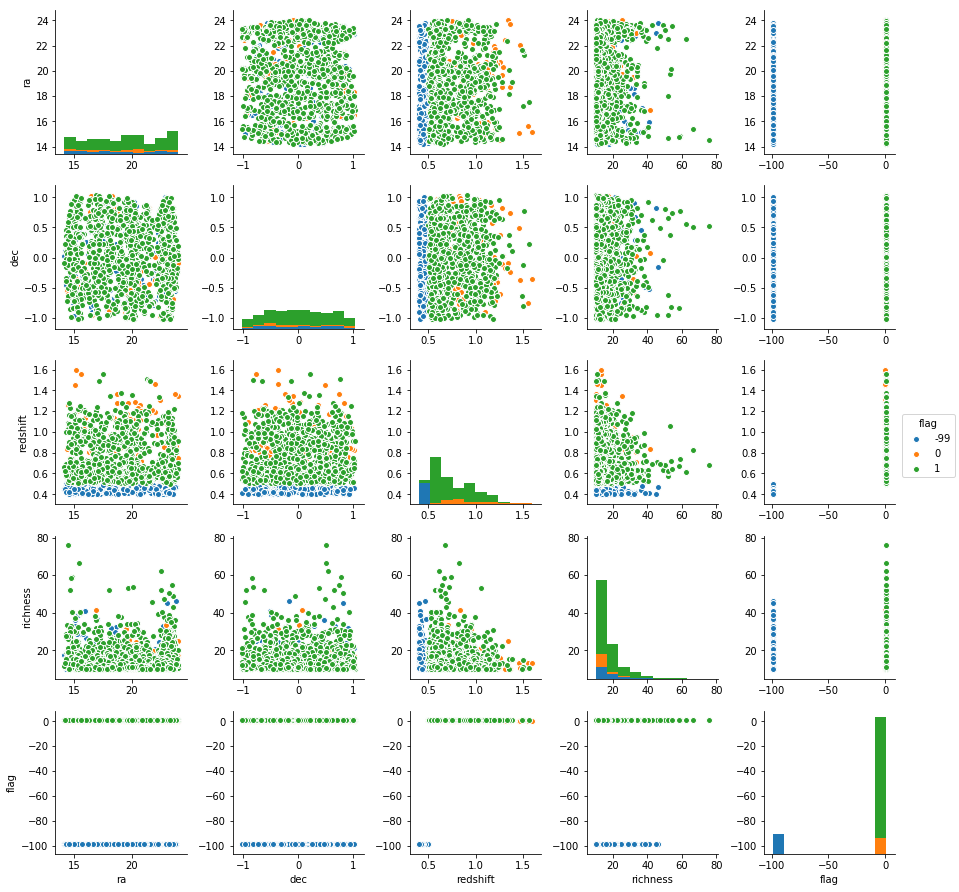

In [6]:
sns.pairplot(data=sheladf,hue='flag')

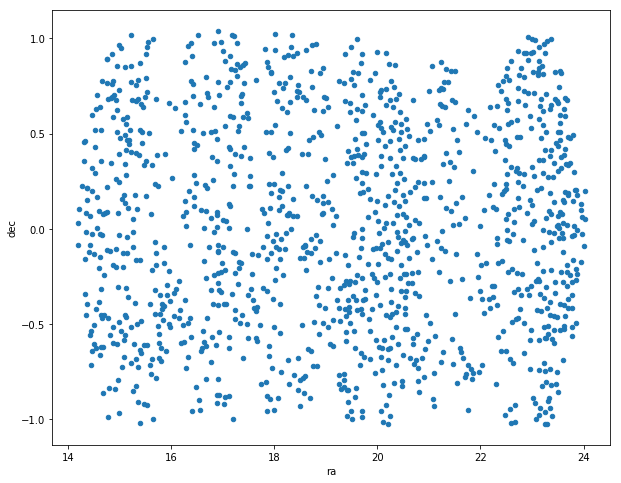

In [7]:
sheladf.plot('ra','dec',kind='scatter',figsize=(10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a15e20f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1669a850>]], dtype=object)

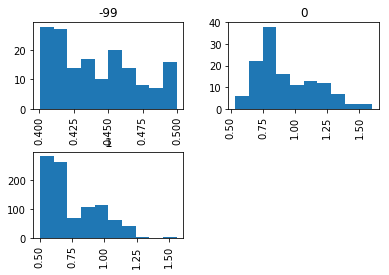

In [8]:
sheladf.hist(by='flag',column='redshift')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1672a290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a16c73e50>]], dtype=object)

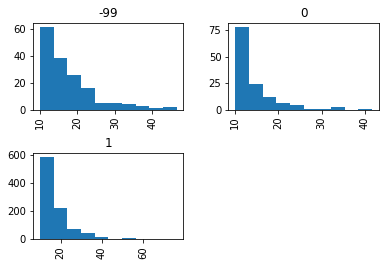

In [9]:
sheladf.hist(by='flag',column='richness')

In [10]:
sheladf.groupby('flag').describe()[['redshift','richness']]

redshift                                                              \
        count      mean       std       min       25%       50%       75%   
flag                                                                        
-99     161.0  0.441440  0.029946  0.400296  0.415340  0.435025  0.463729   
 0      129.0  0.927204  0.223939  0.534034  0.770486  0.850225  1.100330   
 1      953.0  0.760053  0.208352  0.501509  0.593399  0.674321  0.917802   

               richness                                                        \
           max    count       mean       std        min        25%        50%   
flag                                                                            
-99   0.499620    161.0  17.294161  7.144633  10.041986  11.994623  15.030363   
 0    1.596683    129.0  14.086566  5.262681  10.011477  10.728460  12.375998   
 1    1.559883    953.0  17.265543  8.001513  10.011477  11.964113  14.740519   

                            
            75%        max  
flag                        
-99   19.881445  46.394592  
 0    15.060873  41.589272  
 1    19.606855  76.004494

In [11]:
rbindf = sheladf.copy()

def label_rbin(row):
    if row.richness < 20.:
        return 0
    if row.richness >= 20.:
        return 1

rbindf['rbin'] = rbindf.apply(label_rbin,axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a16d167d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a16e28210>], dtype=object)

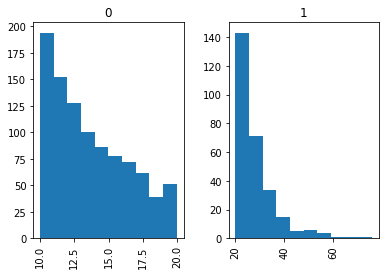

In [12]:
rbindf.hist(by='rbin',column='richness')

In [13]:
#save catalog with richness bins added
rbindf.to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin.dat',index_label='#mem_match_id',sep='\t')

In [14]:
#remove clusters near ACT detections
actra = [14.7912, 14.5081]
actdec = [-0.850114, 0.515512]

actdf = rbindf.copy()

def label_actdet(row):
    x1 = row.ra-actra[0]
    y1 = row.dec-actdec[0]
    d1 = sqrt(x1**2 + y1**2)*60

    x2 = row.ra-actra[1]
    y2 = row.dec-actdec[1]
    d2 = sqrt(x2**2 + y2**2)*60
    
    if d1<3. or d2<3.:
        return 0
    if d1>=3. and d2>=3.:
        return 1

    
actdf['act_det'] = actdf.apply(label_actdet,axis=1)
actdf.groupby('act_det').count()

,ra,dec,redshift,richness,flag,rbin
act_det,,,,,,
0,2,2,2,2,2,2
1,1241,1241,1241,1241,1241,1241


In [15]:
#save catalog without act detected clusters
actdf[actdf.act_det==1].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut.dat',index_label='#mem_match_id',sep='\t')

In [16]:
#save cut catalogs without flag=-99

#all clusters
actdf[(actdf.act_det==1) & (actdf.flag!=-99)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag!=-99)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_stack.dat',index=False,header=False,sep='\t')

#flag 0
actdf[(actdf.act_det==1) & (actdf.flag==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_stack.dat',index=False,header=False,sep='\t')

#flag 1
actdf[(actdf.act_det==1) & (actdf.flag==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_stack.dat',index=False,header=False,sep='\t')


In [17]:
#save cut catalogs without flag=-99
#richness bin 0

#all clusters
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.rbin==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin0.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.rbin==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin0_stack.dat',index=False,header=False,sep='\t')

#flag 0
actdf[(actdf.act_det==1) & (actdf.flag==0) & (actdf.rbin==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin0.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag==0) & (actdf.rbin==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin0_stack.dat',index=False,header=False,sep='\t')

#flag 1
actdf[(actdf.act_det==1) & (actdf.flag==1) & (actdf.rbin==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin0.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag==1) & (actdf.rbin==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin0_stack.dat',index=False,header=False,sep='\t')


In [18]:
#save cut catalogs without flag=-99
#richness bin 1

#all clusters
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.rbin==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin1.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.rbin==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin1_stack.dat',index=False,header=False,sep='\t')

#flag 0
actdf[(actdf.act_det==1) & (actdf.flag==0) & (actdf.rbin==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin1.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag==0) & (actdf.rbin==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin1_stack.dat',index=False,header=False,sep='\t')

#flag 1
actdf[(actdf.act_det==1) & (actdf.flag==1) & (actdf.rbin==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin1.dat',index_label='#mem_match_id',sep='\t')
actdf[(actdf.act_det==1) & (actdf.flag==1) & (actdf.rbin==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin1_stack.dat',index=False,header=False,sep='\t')


In [19]:
actdf[actdf.act_det==1].groupby(['rbin','flag']).count()

ra  dec  redshift  richness  act_det
rbin flag                                       
0    -99   122  122       122       122      122
      0    116  116       116       116      116
      1    724  724       724       724      724
1    -99    39   39        39        39       39
      0     13   13        13        13       13
      1    227  227       227       227      227

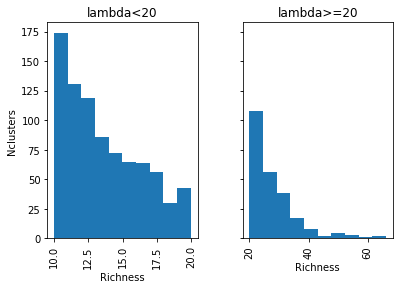

In [20]:
axarr = actdf[(actdf.act_det==1) & (actdf.flag!=-99)].hist(by='rbin',column='richness',sharey=True)
label = ['lambda<20','lambda>=20']
for i,ax in enumerate(axarr.flatten()):
    ax.set_xlabel("Richness")
    ax.set_ylabel("Nclusters")
    ax.set_title(label[i])
    
savefig('plot/Nclusters_rbin.png',bbox_inches='tight')

In [21]:
print 'N > 30'
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.richness>=30)].count()

N > 30


ra          68
dec         68
redshift    68
richness    68
flag        68
rbin        68
act_det     68
dtype: int64

In [22]:
print 'N > 40'
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.richness>=40)].count()

N > 40


ra          18
dec         18
redshift    18
richness    18
flag        18
rbin        18
act_det     18
dtype: int64

In [23]:
print 'N 20-30'
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.richness>=20) & (actdf.richness<30)].count()

N 20-30


ra          172
dec         172
redshift    172
richness    172
flag        172
rbin        172
act_det     172
dtype: int64

In [24]:
print 'N 15-20'
actdf[(actdf.act_det==1) & (actdf.flag!=-99) & (actdf.richness>=15) & (actdf.richness<20)].count()

N 15-20


ra          254
dec         254
redshift    254
richness    254
flag        254
rbin        254
act_det     254
dtype: int64

In [25]:
actdf[actdf.flag!=-99].groupby('rbin').describe()['redshift']

,count,mean,std,min,25%,50%,75%,max
rbin,,,,,,,,
0,840.0,0.797019,0.224326,0.501509,0.610267,0.723577,0.961146,1.596683
1,242.0,0.720844,0.177694,0.504169,0.589627,0.645412,0.839738,1.345644


In [26]:
#make 3 richness bins, get rid of flag=-99, richness<10, act detections

rbindf2 = actdf[(actdf.flag!=-99) & (actdf.richness>=10) & (actdf.act_det==1)].copy()

def label_rbin2(row):
    if (row.richness < 20.):
        return 0
    if (row.richness >= 20.) & (row.richness < 30.):
        return 1
    if (row.richness >= 30.):
        return 2

rbindf2['rbin'] = rbindf2.apply(label_rbin2,axis=1)

In [27]:
rbindf2.head()

,ra,dec,redshift,richness,flag,rbin,act_det
mem_match_id,,,,,,,
47,15.426018,0.507417,0.826262,66.287079,1,2,1
48,22.537474,0.662808,0.574201,52.054184,1,2,1
54,15.187095,0.465094,0.605872,29.964983,1,1,1
71,23.608549,-0.048012,0.633663,49.003189,1,2,1
72,23.528387,0.004563,0.714510,16.815195,0,0,1


In [28]:
rbindf2.groupby('rbin').describe()[['redshift','richness']]

redshift                                                              \
        count      mean       std       min       25%       50%       75%   
rbin                                                                        
0       840.0  0.797019  0.224326  0.501509  0.610267  0.723577  0.961146   
1       172.0  0.730894  0.189188  0.504169  0.587976  0.653540  0.873611   
2        68.0  0.696787  0.145992  0.519543  0.590904  0.632117  0.785516   

               richness                                                        \
           max    count       mean       std        min        25%        50%   
rbin                                                                            
0     1.596683    840.0  13.618412  2.726350  10.011477  11.289081  12.963314   
1     1.345644    172.0  23.923655  2.905284  20.003485  21.376432  23.069735   
2     1.178673     68.0  37.979679  8.649521  30.071768  31.574383  34.152473   

                            
            75%        max  
rbin                        
0     15.568101  19.957720  
1     26.280907  29.964983  
2     40.284971  66.287079

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16ea3310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a17221150>]], dtype=object)

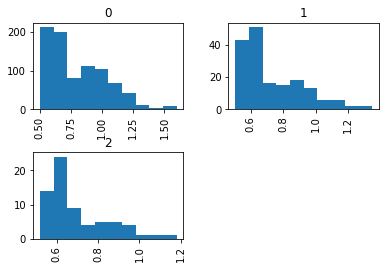

In [29]:
rbindf2.hist(column='redshift',by='rbin')

In [30]:
#save catalogs

#all clusters
rbindf2.to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut.dat',index_label='#mem_match_id',sep='\t')

#rbin 0, all flags
rbindf2[(rbindf2.rbin==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin0.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin0_stack.dat',index=False,header=False,sep='\t',)

rbindf2[(rbindf2.rbin==0) & (rbindf2.flag==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin0.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==0) & (rbindf2.flag==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin0_stack.dat',index=False,header=False,sep='\t')

rbindf2[(rbindf2.rbin==0) & (rbindf2.flag==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin0.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==0) & (rbindf2.flag==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin0_stack.dat',index=False,header=False,sep='\t')


#rbin 1
rbindf2[(rbindf2.rbin==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin1.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin1_stack.dat',index=False,header=False,sep='\t')

rbindf2[(rbindf2.rbin==1) & (rbindf2.flag==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin1.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==1) & (rbindf2.flag==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin1_stack.dat',index=False,header=False,sep='\t')

rbindf2[(rbindf2.rbin==1) & (rbindf2.flag==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin1.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==1) & (rbindf2.flag==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin1_stack.dat',index=False,header=False,sep='\t')


#rbin 2
rbindf2[(rbindf2.rbin==2)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin2.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==2)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist01_rbin2_stack.dat',index=False,header=False,sep='\t')

rbindf2[(rbindf2.rbin==2) & (rbindf2.flag==0)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin2.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==2) & (rbindf2.flag==0)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist0_rbin2_stack.dat',index=False,header=False,sep='\t')

rbindf2[(rbindf2.rbin==2) & (rbindf2.flag==1)].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin2.dat',index_label='#mem_match_id',sep='\t')
rbindf2[(rbindf2.rbin==2) & (rbindf2.flag==1)][['ra','dec']].to_csv('~/Dropbox/copy/shela/shela_2018/data/shela_cat_rbin_cut_zdist1_rbin2_stack.dat',index=False,header=False,sep='\t')


In [32]:
rbindf2.groupby(['rbin','flag']).count()

ra  dec  redshift  richness  act_det
rbin flag                                       
0    0     116  116       116       116      116
     1     724  724       724       724      724
1    0       9    9         9         9        9
     1     163  163       163       163      163
2    0       4    4         4         4        4
     1      64   64        64        64       64